# Tutorial 1: Getting started with FastEstimator
_____

#### In FastEstimator, there are 3 APIs that you need to know:

* __Pipeline__: takes care of loading and preprocessing data.
* __Network__: responsible for trainable and differentiable models, operations and loss.
* __Estimator__: manages the training loop.

Any deep learning implementation will follow the `Pipeline` -> `Network` -> `Estimator` process as illustrated below:
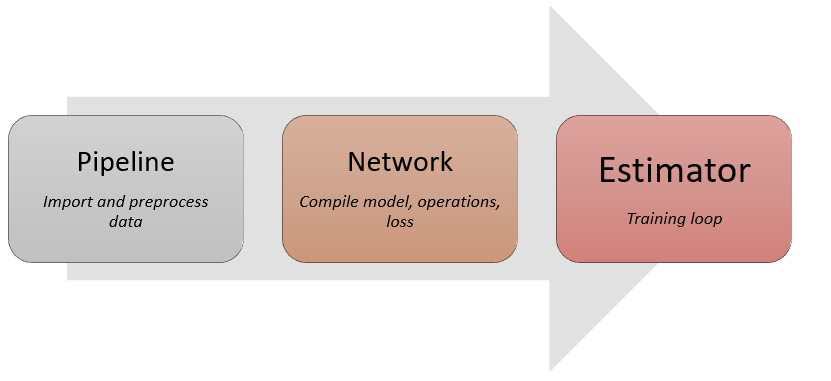

Pipeline operations will usually happen on CPU, whereas Network operations will happen on GPU when available.


In [ ]:
import tensorflow as tf
import numpy as np

## Step 1: Prepare the Pipeline

For in-memory data, `Pipeline` can take a nested **dictionary** like `{"train": {"x": x_train, "y": y_train}, "eval": {"x": x_eval, "y": y_eval}}`.  For both training and validation data, we link the images and labels to a key (respectively "x" and "y"). Note that the `eval` part is not needed, if validation data is not available.  
We will explain `ops` arguments in more details in tutorial 3.

In [1]:
import fastestimator as fe
from fastestimator.op.tensorop import Minmax

# Import training and validation data as numpy array for instance
(x_train, y_train), (x_eval, y_eval) = tf.keras.datasets.mnist.load_data()

# Add one channel dimension for convolution later
x_train = np.expand_dims(x_train, -1) 
x_eval = np.expand_dims(x_eval, -1) 

# Create a dictionary to identify the training and evaluation data.
# We specify for each x (images) and y (label) also in a dictionnary.
data = {"train": {"x": x_train, "y": y_train}, "eval": {"x": x_eval, "y": y_eval}}

# Creating the pipeline with the desired batch_size and preprocessing operation (here Minmax).
pipeline = fe.Pipeline(batch_size=32, data=data, ops=Minmax(inputs="x", outputs="x"))

## Step 2: Define the network

For Network architecture, users can choose one of the following:
* Define a custom network architecture using  `tf.keras.Model` or `tf.keras.Sequential`.  
* Use an existing architecture provided by `tf.keras.applications` or `fe.architecture`. 

    In this tutorial, we are going to import a pre-defined LeNet architecture in [fastestimator.architecture.lenet](https://github.com/fastestimator/fastestimator/blob/master/fastestimator/architecture/lenet.py).

Once the architecture is defined, we have to associate the model with its optimizer and expected loss name using fe.build.

Finally, we create the Network to summarize all operations and loss. In this case, we have one ModelOp where we specify the input key, model we want to use, and output key.
Network is also where we define the loss, here SparseCategoricalCrossentropy. We specify the key for predictions and groundtruths and the loss name as output. 

In [2]:
from fastestimator.architecture import LeNet
from fastestimator.op.tensorop.model import ModelOp
from fastestimator.op.tensorop.loss import SparseCategoricalCrossentropy

# We first define a model, using FEModel to compile it.
model = fe.build(model_def=LeNet, model_name="lenet", optimizer="adam", loss_name="loss")

# We summarize all operations and loss in the Network.
network = fe.Network(ops=[ModelOp(inputs="x", model=model, outputs="y_pred"), 
                          SparseCategoricalCrossentropy(y_pred="y_pred", y_true="y", outputs="loss")])

## Step 3: Create the Estimator...

`Estimator` takes both `pipeline` and `network` and combines them into the training loop. Here's the basic usage of `Estimator`. 

In [3]:
# We create the estimator and specify the number of epochs for training.
estimator = fe.Estimator(network=network, pipeline=pipeline, epochs=2)

## ... and train your model!

Since the data is already loaded in memory, the training is happening without any disk reading. We only have to call the fit method to launch the training!

In [4]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 0; total_train_steps: 3750; lenet_lr: 0.001; 
FastEstimator-Train: step: 0; loss: 2.3033283; 
FastEstimator-Train: step: 100; loss: 0.1509019; examples/sec: 3971.5; progress: 2.7%; 
FastEstimator-Train: step: 200; loss: 0.2812658; examples/sec: 4029.8; progress: 5.3%; 
FastEstimator-Train: step: 300; loss: 0.1028314; examples/sec: 4061.3; progress: 8.0%; 
FastEstimator-Train: step: 400; loss: 0.381653; examples/sec: 4030.7; progress: 10.7%; 
FastEstimato

___
> ## Key take-aways:
>
> In order to implement your own ideas in FastEstimator, you first need to conceptually walk through the same thought process.
>1. How do I want my data to be processed during the training? _Express this in `Pipeline`_.
>2. How do I want my network architecture and loss to be defined? What are the connections between networks if there are multiple of them? _Express this in `Network`_.
>3. How long do I want to train my model? What do I need during training loop? _Express this in `Estimator`_.
>
>It is important to note that the preprocessing defined in `Pipeline` will be executed repeatedly for each batch during the training loop. However, some preprocessing only needs to happen once and for all (for instance resizing and rescaling). Next tutorial will introduce how to deal with this case.